In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import os
# Use PrettyTensor to simplify Neural Network construction.
import prettytensor as pt
import sys
import load_data
from load_data import img_size, num_channels, num_classes

# image preprocessing function

In [2]:
# for train dataset random crop, flip left to right， contrast..
# for test dataset resize_image_with_crop_or_pad
def pre_process_image(image, training):
    # This function takes a single image as input,
    # and a boolean whether to build the training or testing graph. 
    if training:
        # For training, add the following to the TensorFlow graph.
        # Randomly crop the input image.
        image = tf.random_crop(image, size=[img_size_cropped, img_size_cropped, num_channels])
        # Randomly flip the image horizontally.
        image = tf.image.random_flip_left_right(image)      
        # Randomly adjust contrast and saturation.
        image = tf.image.random_brightness(image, max_delta=63)
        image = tf.image.random_contrast(image, lower=0.2, upper=1.8)
        # Some of these functions may overflow and result in pixel
        # values beyond the [0, 1] range. A simple solution is to limit the range.
        # Limit the image pixels between [0, 1] in case of overflow.
        image = tf.minimum(image, 1.0)
        image = tf.maximum(image, 0.0)
    else:
        # For training, add the following to the TensorFlow graph.
        # Crop the input image around the centre so it is the same
        # size as images that are randomly cropped during training.
        image = tf.image.resize_image_with_crop_or_pad(image,
                            target_height=img_size_cropped,
                            target_width=img_size_cropped)
    return image

# image processing function

In [3]:
def pre_process(images, training):
    # Use TensorFlow to loop over all the input images and call
    # the function above which takes a single image as input.
    images = tf.map_fn(lambda image: pre_process_image(image, training), images)
    return images

# 3-conv-layer function with Pretty Tensor framework

In [4]:
def main_network(images, training):
    # Wrap the input images as a Pretty Tensor object.
    x_pretty = pt.wrap(images)
    # Pretty Tensor uses special numbers to distinguish between
    # the training and testing phases.
    if training:
        phase = pt.Phase.train
    else:
        phase = pt.Phase.infer
    # Create the convolutional neural network using Pretty Tensor.
    # It is very similar to the previous tutorials, except
    # the use of so-called batch-normalization in the first layer.
    with pt.defaults_scope(activation_fn=tf.nn.relu, phase=phase):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=32, name='layer_conv1', batch_normalize=True).\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=3, depth=32, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=32, name='layer_conv3').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=256, name='layer_fc1').\
            fully_connected(size=128, name='layer_fc2').\
            softmax_classifier(num_classes, labels=y_true)
    return y_pred, loss

# build network function

In [5]:
def create_network(training):
    # Wrap the neural network in the scope named 'network'.
    # Create new variables during training, and re-use during testing.
    with tf.variable_scope('network', reuse=not training):
        # Just rename the input placeholder variable for convenience.
        images = x
        # Create TensorFlow graph for pre-processing.
        images = pre_process(images=images, training=training)
        # Create TensorFlow graph for the main processing.
        y_pred, loss = main_network(images=images, training=training)
    return y_pred, loss

# random batch function

In [6]:
def random_batch():
    # Number of images in the training-set.
    num_images = len(images_train)
    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    # Use the random index to select random images and labels.
    x_batch = images_train[idx, :, :, :]
    y_batch = labels_train[idx, :]
    return x_batch, y_batch

# optimization function

In [7]:
# every 100 iterations print train accuracy, 1000 iterations save trained network
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()
    for i in range(num_iterations):
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch, y_true: y_true_batch}
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)
        # Print status every 100 iterations
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy, feed_dict=feed_dict_train)
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))
        # Save a checkpoint to disk every 1000 iterations
        if (i_global % 1000 == 0) or (i == num_iterations - 1):
            # Save all variables of the TensorFlow graph to a
            # checkpoint. Append the global_step counter
            # to the filename so we save the last several checkpoints.
            saver.save(session, save_path=save_path, global_step=global_step)
            print("Saved checkpoint.")
    # Ending time.
    end_time = time.time()
    time_dif = end_time - start_time
    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

# define 3*3 figures plot function

In [8]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):
    assert len(images) == len(cls_true) == 9
    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)
    # Adjust vertical spacing if we need to print ensemble and best-net.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)
    for i, ax in enumerate(axes.flat):
        # Interpolation type.
        if smooth:
            interpolation = 'spline16'
        else:
            interpolation = 'nearest'
        # Plot image.
        ax.imshow(images[i, :, :, :],
                  interpolation=interpolation)            
        # Name of the true class.
        cls_true_name = class_names[cls_true[i]]
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true_name)
        else:
            # Name of the predicted class.
            cls_pred_name = class_names[cls_pred[i]]
            xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)
        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)      
        ax.set_xticks([])
        ax.set_yticks([])  
    plt.savefig("result/prediction_demo.png")
    plt.show()

# example error function

In [9]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.
    # cls_pred is an array of the predicted class-number for all images in the test-set.
    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.
    # Negate the boolean array.
    incorrect = (correct == False)  
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]   
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]
    # Get the true classes for those images.
    cls_true = cls_test[incorrect]    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

# confusion matrix function

In [10]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.
    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, class_names[i])
        print(cm[i, :], class_name)
    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

# predict class function

In [11]:
def predict_cls(images, labels, cls_true):
    # Number of images.
    num_images = len(images)
    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)
    # Now calculate the predicted classes for the batches.
    i = 0
    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)
        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: images[i:j, :], y_true: labels[i:j, :]}
        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)
        # Set the start-index for the next batch to the end-index of the current batch.
        i = j
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)
    return correct, cls_pred

def predict_cls_test():
    return predict_cls(images = images_test, labels = labels_test, cls_true = cls_test)

# classification accuracy function

In [12]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # calculating: number of True / len(correct)    
    # Return the classification accuracy and the number of correct classifications.
    return correct.mean(), correct.sum()

# print accuracy function

In [13]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):
    # For all the images in the test-set, calculate the predicted classes.
    correct, cls_pred = predict_cls_test()   
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)   
    # Number of images being classified.
    num_images = len(correct)
    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))
    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)
    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix: N/A")
        plot_confusion_matrix(cls_pred=cls_pred)

# load data

In [14]:
# labels_train([0,0,0,0,0,0,1,0,0,0,0,0])
images_train, cls_train, labels_train = load_data.load_training_data()
images_test, cls_test, labels_test = load_data.load_test_data()

Loading data: ../../dataset/12_classes/dataset-batches-py-256/train_batch_1
Loading data: ../../dataset/12_classes/dataset-batches-py-256/train_batch_2
Loading data: ../../dataset/12_classes/dataset-batches-py-256/train_batch_3
Loading data: ../../dataset/12_classes/dataset-batches-py-256/train_batch_4
Loading data: ../../dataset/12_classes/dataset-batches-py-256/train_batch_5
Loading data: ../../dataset/12_classes/dataset-batches-py-256/test_batch


# placeholder

In [15]:
x = tf.placeholder(tf.float32, shape=[None, img_size, img_size, num_channels], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
# each in y_true array < 1
y_true_cls = tf.argmax(y_true, dimension=1)

# images preprocessing

In [16]:
# setting cropping size, raw image size is 256*256
img_size_cropped = 24
distorted_images = pre_process(images=x, training=True)

# define loss and accuracy

In [17]:
# set trainable=False means no optimization
global_step = tf.Variable(initial_value=0,
              name='global_step', trainable=True)

# calculate loss
_, loss = create_network(training=True)
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(
            loss, global_step=global_step)

# prediction
y_pred, _ = create_network(training=False)
y_pred_cls = tf.argmax(y_pred, dimension=1)
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

# accuracy
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# session startup

In [18]:
session = tf.Session()
session.run(tf.global_variables_initializer())

# define trained network saver()

In [19]:
save_dir = '../../dataset/12_classes/checkpoints/'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
save_path = save_dir + 'motion_recog_cnn'
saver = tf.train.Saver()

# train and accuracy test

Loading data: ../../dataset/12_classes/dataset-batches-py-256/batches.meta
Global Step:    100, Training Batch Accuracy:   7.8%
Global Step:    200, Training Batch Accuracy:   6.2%
Global Step:    300, Training Batch Accuracy:  14.1%
Global Step:    400, Training Batch Accuracy:   9.4%
Global Step:    500, Training Batch Accuracy:  15.6%
Global Step:    600, Training Batch Accuracy:   9.4%
Global Step:    700, Training Batch Accuracy:  12.5%
Global Step:    800, Training Batch Accuracy:  17.2%
Global Step:    900, Training Batch Accuracy:  14.1%
Global Step:   1000, Training Batch Accuracy:   6.2%
Saved checkpoint.
Global Step:   1100, Training Batch Accuracy:  18.8%
Global Step:   1200, Training Batch Accuracy:  10.9%
Global Step:   1300, Training Batch Accuracy:   9.4%
Global Step:   1400, Training Batch Accuracy:  10.9%
Global Step:   1500, Training Batch Accuracy:  10.9%
Global Step:   1600, Training Batch Accuracy:  21.9%
Global Step:   1700, Training Batch Accuracy:  20.3%
Global

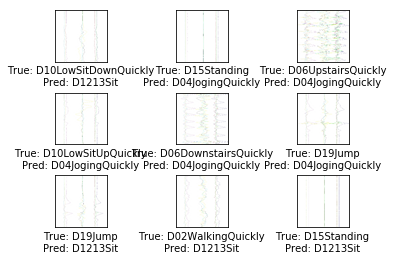

Confusion Matrix: N/A
(array([ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0, 13]), '(0) D02WalkingQuickly')
(array([ 0, 16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  4]), '(1) D04JogingQuickly')
(array([ 0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2]), '(2) D06DownstairsQuickly')
(array([ 0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1]), '(3) D06UpstairsQuickly')
(array([ 0, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9]), '(4) D10LowSitDownQuickly')
(array([ 0, 12,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5]), '(5) D10LowSitUpQuickly')
(array([ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11]), '(6) D14LyBack')
(array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6]), '(7) D14LyLateral')
(array([ 0,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0, 11]), '(8) D15Standing')
(array([0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]), '(9) D18Stumble')
(array([ 0, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7]), '(10) D19Jump')
(array([ 0,  6,  0,  0,  0,  0,  0,  0,  0,  0,  0, 14]), '(11) D1213Sit')
 (0) (1) (2) (3) (4) (5) (6) (7) (8) (9) (

In [20]:
# small batch size for calculation efficiency
train_batch_size = 64

# Split the dataset to limit RAM usage.
batch_size = 256

# show classes' name
class_names = load_data.load_class_names()
optimize(num_iterations=10000)
print_test_accuracy(show_example_errors=True, show_confusion_matrix=True)

#sys.path.append('./')

# accuracy of each class prediction

In [21]:
# build class dict
y_true_cls = np.argmax(labels_test, 1)
correct, cls_pred = predict_cls_test() 
#cls_num = set(y_true_cls)
#cls_dict = dict.fromkeys(cls_num)

cls_dict = dict()
for cls_index, cls in enumerate(y_true_cls):
    if cls in cls_dict.keys():  
        cls_dict[cls].append(cls_index)  
    else:  
        cls_dict[cls] = [cls_index]

pre_dict = dict()
for i in cls_dict.keys():
    pre_dict[i] = [correct[j] for j in cls_dict[i]]

# calculate each class accuracy
accu_dict = dict.fromkeys(pre_dict.keys())
for i in pre_dict.keys():
    cls_sum = len(pre_dict[i])
    pre_true = pre_dict[i].count(True)
    accu = pre_true*1.0/cls_sum
    accu_dict[i] = accu

accu_cls = dict.fromkeys(class_names)
for i in range(len(class_names)):
    accu_cls[class_names[i]] = float('%0.4f' % accu_dict[i])

print("Accuracy of each class prediction: ")
print(accu_dict)
print("Accuracy of each classname: ")
print(accu_cls)

session.close()

Accuracy of each class prediction: 
{0: 0.0, 1: 0.8, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.7}
Accuracy of each classname: 
{u'D18Stumble': 0.0, u'D14LyBack': 0.0, u'D19Jump': 0.0, u'D10LowSitUpQuickly': 0.0, u'D1213Sit': 0.7, u'D02WalkingQuickly': 0.0, u'D14LyLateral': 0.0, u'D04JogingQuickly': 0.8, u'D15Standing': 0.0, u'D06UpstairsQuickly': 0.0, u'D06DownstairsQuickly': 0.0, u'D10LowSitDownQuickly': 0.0}
